In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

# Non pythonic hack to reuse some utility code
if sys.path[0] != '../py_utils':
    sys.path.insert(0,'../py_utils')

import utils
import file_utils
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from pathlib import Path
%matplotlib inline
pd.set_option('display.max_columns', 500)
print("Seaborn version: ", sns.__version__)

Seaborn version:  0.9.0


In [2]:
def eliminate_features(classifier, X, y ):
    iteration = 0
    print("Iteration= ", iteration)
    iteration += 1
    model_stats = {}
    drop_list = []
    # get baseline by identifying sorted important features using all of the provided features
    model_stats = utils.save_model_stats(classifier,X,y,model_stats)
    
    important_features = utils.display_important_features(classifier.feature_importances_, X,0)
    # least important feature
    least_important_label = important_features[-1][0]
    print("least_important label= ", least_important_label)
    
    drop_list.append(least_important_label)
    del important_features[-1]
    
    # drop list contains all of the feature labels except for the feature label identified as being most important
    list_count = len(important_features)
    while list_count > 0:
        print("Iteration= ", iteration)
        iteration += 1
        model_stats = utils.save_model_stats(classifier,X.drop(columns=drop_list),y,model_stats)
        least_important_label = important_features[-1][0]
        print("least_important label= ", least_important_label)
        drop_list.append(least_important_label)
        del important_features[-1]
        list_count-=1
    return model_stats


In [3]:
def get_missed_predictions(tourney_comp_ratings, model_features, prediction_probabilities, X, y, y_pred):
    
    pred_probs = pd.Series(prediction_probabilities[:,1], index=X.index)
    predictions = pd.Series(y_pred, index=y.index)
    test_games = tourney_comp_ratings[tourney_comp_ratings.index.isin(X.index)].copy()
    test_games['predicted_result'] = predictions
    test_games['pred_win_prob'] = pred_probs
    missed_predictions = test_games[test_games['game_result'] != 
                                test_games['predicted_result']].sort_values(by='pred_win_prob', ascending=False)
   
    missed_predictions.apply(lambda x: feature_dictionary.print_game_info(test_games,x['season_t'], x['round'], x['team_t'] ), axis=1)
    supporting_features = missed_predictions.apply(lambda row: utils.get_supporting_features(row,
                                                                                         feature_dictionary, 
                                                                                         feature_list),axis=1)

    supporting_model_features = missed_predictions.apply(lambda row: utils.get_supporting_features(row, 
                                                                                               feature_dictionary,
                                                                                               model_features),axis=1)
    
    missed_predictions = missed_predictions.merge(supporting_features.to_frame(name='supporting_features'),how='left',
                                              left_index=True, right_index=True)

    missed_predictions = missed_predictions.merge(supporting_model_features.to_frame(name='supporting_model_features'),how='left', 
                                              left_index=True, right_index=True)

    missed_predictions['features'] = 100 * missed_predictions['supporting_features'].apply(lambda x: len(x)) / len(feature_list)

    missed_predictions['model_features'] = 100 * missed_predictions['supporting_model_features'].apply(lambda x: len(x)) / \
        len(model_features)

    missed_predictions['game_index'] = missed_predictions.index
    
    return missed_predictions

In [4]:
summary_team_file = '../Data/sr_summaries_kaggle_id_no_opp_2018.csv'
team_meta_data_file = '../Data/D1_teams.csv'
tournament_data_file = '../Data/tournament_results_2018.csv'
rankings_data_file = '../data/massey_seasons_with_id.csv'

feature_dictionary = utils.Feature_Dictionary()

In [5]:
# earliest season data starts in 2000 corresponding to tournament season date of 2001
start_tournament = 2003
stop_tournament = 2017

#### Read in regular season team statistics from SRCBB https://www.sports-reference.com/cbb/

In [6]:
summary_data = file_utils.read_summary_team_data(summary_team_file)
teams = file_utils.read_team_meta_data(team_meta_data_file)
summary_data.head()


,season,school,team_id,games,srs,sos,win_pct,pts_avg,opp_pts_avg,fg_pct,ft_pct,poss_avg,off_rebs_avg,def_rebs_avg,to_avg,steal_avg,off_rating,ft_att_avg
0,2000,Air Force,aa7af640-5762-4686-9181-39f7b8a8186e,29,-3.57,1.99,0.276,57,63,0.435,0.697,63.020690,6.0,16.0,13,7,90.446487,16
1,2000,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,28,-3.09,1.67,0.429,67,72,0.452,0.725,73.857143,9.0,20.0,15,5,90.715667,23
2,2000,Alabama,c2104cdc-c83d-40d2-a3cd-df986e29f5d3,36,14.02,6.27,0.694,76,68,0.433,0.698,86.200000,16.0,26.0,15,7,88.167053,24
3,2000,Alabama A&M,949c3398-85e4-4c63-ba71-9a82e06ddea4,28,-13.46,-11.79,0.607,73,74,0.391,0.626,94.264286,17.0,22.0,16,12,77.441843,23
4,2000,Alabama State,267d417a-8f85-4c87-a15a-068c089a74c6,31,-8.86,-13.61,0.710,68,63,0.441,0.658,80.690323,12.0,25.0,16,8,84.272807,22


#### Read table of team names and associated team meta data from the Kaggle data set.

https://console.cloud.google.com/bigquery?project=bigqueryncaa&p=bigquery-public-data&d=ncaa_basketball&page=dataset

#### Read in the NCAA Men's Tournament results from the the Kaggle data set.

In [7]:
tourney_data = file_utils.read_tournament_results(tournament_data_file,start_tournament)
game_data = utils.compute_game_data(tourney_data, teams)
computer_rankings = pd.read_csv(Path(rankings_data_file))
computer_rankings = computer_rankings[computer_rankings['season'] >= start_tournament]

tourney_data = utils.recode_tourney_data(tourney_data)
tourney_data = file_utils.merge_tourney_summary_data(tourney_data, summary_data)
tourney_data = file_utils.join_tourney_team_data(tourney_data, teams)
tourney_comp_ratings = file_utils.merge_tourney_ranking_data(tourney_data, computer_rankings)
tourney_comp_ratings = utils.implement_top_conference_feature(tourney_data, teams, game_data, tourney_comp_ratings)
tourney_comp_ratings = utils.implement_seed_threshold_feature(tourney_comp_ratings)
tourney_comp_ratings = utils.compute_delta_features(tourney_comp_ratings)

tourney_comp_ratings.dropna(inplace=True)
tourney_comp_ratings[tourney_comp_ratings.isnull().any(axis=1)]


,season_t,round,game_date,seed_t,team_t,team_id_t,win_pts,seed_o,team_o,team_id_o,lose_pts,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf_t,top_conf_o,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor


In [8]:
feature_data = tourney_comp_ratings.drop(columns=['round','game_date','seed_t','team_t','team_id_t','team_id_o',
                                         'team_o','seed_o','team_id_o','game_result','start_season','game result',
                                         'conf_name_t','conf_name_o']).copy()


feature_data.head()

,season_t,win_pts,lose_pts,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf_t,top_conf_o,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor
0,2003,60,58,14.05,6.11,0.697,81.0,73.0,0.458,0.774,85.363636,11.0,24.0,15.0,7.0,94.888179,20.0,11.00,5.25,0.758,66.0,60.0,0.451,0.711,71.333333,10.0,23.0,12.0,4.0,92.523364,18.0,30,43.0,33,36,32.0,42.0,29.0,50.0,27,38,31.0,25,34,20.0,37.0,33.0,16.0,66,0,0,0,8.0,6.0,2.0,0.007,1.0,1.0,0.063,8.0,8.0,0.0,-0.061,2.364814,2.0,-1,3.05,0.86,-8,12.0,8,2,12.0,5.0,-4.0,34.0,-39
1,2003,85,55,18.54,7.76,0.758,75.0,64.0,0.476,0.703,76.945455,10.0,24.0,13.0,7.0,97.471645,18.0,-1.65,-6.87,0.767,72.0,65.0,0.459,0.705,79.620000,11.0,25.0,15.0,8.0,90.429540,23.0,7,11.0,11,10,14.0,6.0,8.0,15.0,7,138,102.0,115,143,87.0,134.0,93.0,91.0,169,1,0,1,11.0,7.0,4.0,0.017,-1.0,-1.0,-0.002,6.0,7.0,-1.0,-0.009,7.042104,-5.0,-13,20.19,14.63,-131,-91.0,-104,-133,-73.0,-128.0,-85.0,-76.0,-162
2,2003,68,62,16.96,6.96,0.806,77.0,67.0,0.453,0.752,83.167742,14.0,26.0,15.0,6.0,92.583973,26.0,12.68,8.34,0.647,70.0,65.0,0.465,0.660,79.558824,12.0,23.0,15.0,7.0,87.985213,20.0,9,9.0,4,7,8.0,12.0,4.0,7.0,20,43,47.0,40,40,44.0,45.0,43.0,36.0,44,0,0,1,10.0,5.0,5.0,-0.012,2.0,3.0,0.092,9.0,8.0,1.0,0.159,4.598761,6.0,-8,4.28,-1.38,-34,-38.0,-36,-33,-36.0,-33.0,-39.0,-29.0,-24
3,2003,65,63,12.68,8.34,0.647,70.0,65.0,0.465,0.660,79.558824,12.0,23.0,15.0,7.0,87.985213,20.0,14.61,3.71,0.767,70.0,59.0,0.443,0.686,75.666667,11.0,24.0,12.0,7.0,92.511013,20.0,43,47.0,40,40,44.0,45.0,43.0,36.0,44,20,16.0,27,28,27.0,18.0,22.0,27.0,38,1,0,0,5.0,11.0,-6.0,0.022,1.0,-1.0,-0.026,8.0,5.0,3.0,-0.120,-4.525801,0.0,3,-1.93,4.63,23,31.0,13,12,17.0,27.0,21.0,9.0,6
4,2003,95,84,18.91,9.27,0.788,79.0,69.0,0.446,0.721,85.248485,16.0,25.0,13.0,6.0,92.670269,24.0,19.02,9.02,0.857,79.0,69.0,0.475,0.694,84.640000,13.0,27.0,14.0,8.0,93.336484,23.0,5,7.0,7,6,4.0,7.0,7.0,4.0,12,12,14.0,5,12,9.0,15.0,5.0,9.0,21,0,0,0,10.0,10.0,0.0,-0.029,3.0,-2.0,0.027,7.0,6.0,1.0,-0.069,-0.666215,1.0,-2,-0.11,0.25,-7,-7.0,2,-6,-5.0,-8.0,2.0,-5.0,-9


In [9]:
feature_data.drop(columns=['pts_avg_t','pts_avg_o', 'opp_pts_avg_t','opp_pts_avg_o',
                                'margin_victory_avg_t', 'margin_victory_avg_o',
                                'poss_avg_t','poss_avg_o',
                                'fg_pct_t','fg_pct_o',
                                'off_rebs_avg_t','off_rebs_avg_o','def_rebs_avg_t','def_rebs_avg_o',
                                'ft_pct_t','ft_pct_o',
                                'to_avg_t','to_avg_o','steal_avg_t','steal_avg_o',
                                'to_net_avg_t','to_net_avg_o',
                                'win_pct_t','win_pct_o','off_rating_t','off_rating_o',
                                'ft_att_avg_t','ft_att_avg_o','opp_pts_avg_t','opp_pts_avg_o',
                                'srs_t','srs_o','sos_t','sos_o',
                                'sag_t','sag_o','wlk_t','wlk_o','wol_t','wol_o',
                                'rth_t','rth_o','col_t','col_o','pom_t','pom_o',
                                'dol_t','dol_o','rpi_t','rpi_o','mor_t','mor_o'], inplace=True)


# for now drop the delta seed features
feature_data.drop(columns=['upset_seed_threshold'], inplace=True)
feature_data.head()

,season_t,win_pts,lose_pts,top_conf_t,top_conf_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor
0,2003,60,58,0,0,2.0,0.007,1.0,1.0,0.063,0.0,-0.061,2.364814,2.0,-1,3.05,0.86,-8,12.0,8,2,12.0,5.0,-4.0,34.0,-39
1,2003,85,55,1,0,4.0,0.017,-1.0,-1.0,-0.002,-1.0,-0.009,7.042104,-5.0,-13,20.19,14.63,-131,-91.0,-104,-133,-73.0,-128.0,-85.0,-76.0,-162
2,2003,68,62,0,0,5.0,-0.012,2.0,3.0,0.092,1.0,0.159,4.598761,6.0,-8,4.28,-1.38,-34,-38.0,-36,-33,-36.0,-33.0,-39.0,-29.0,-24
3,2003,65,63,1,0,-6.0,0.022,1.0,-1.0,-0.026,3.0,-0.120,-4.525801,0.0,3,-1.93,4.63,23,31.0,13,12,17.0,27.0,21.0,9.0,6
4,2003,95,84,0,0,0.0,-0.029,3.0,-2.0,0.027,1.0,-0.069,-0.666215,1.0,-2,-0.11,0.25,-7,-7.0,2,-6,-5.0,-8.0,2.0,-5.0,-9


In [10]:
X= feature_data[feature_data['season_t']<= stop_tournament]
y=tourney_comp_ratings[tourney_comp_ratings['season_t']<= stop_tournament]['game_result']
X= X.drop(columns=['season_t'])

feature_list = list(X)
feature_list

['win_pts',
 'lose_pts',
 'top_conf_t',
 'top_conf_o',
 'delta_margin_victory_avg',
 'delta_fg_pct',
 'delta_off_rebs_avg',
 'delta_def_rebs_avg',
 'delta_ft_pct',
 'delta_to_net_avg',
 'delta_win_pct',
 'delta_off_rating',
 'delta_ft_att_avg',
 'delta_seed',
 'delta_srs',
 'delta_sos',
 'delta_sag',
 'delta_wlk',
 'delta_wol',
 'delta_rth',
 'delta_col',
 'delta_pom',
 'delta_dol',
 'delta_rpi',
 'delta_mor']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 5)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
X_train.head()

(782, 25)
(782,)
(196, 25)
(196,)


,win_pts,lose_pts,top_conf_t,top_conf_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor
784,92,75,0,1,-3.0,-0.015,0.0,-1.0,0.062,2.0,-0.055,-3.232509,-1.0,3,-10.13,-6.65,97,106.0,98,94,88.0,80.0,103.0,81.0,102
125,70,65,0,1,8.0,0.011,-2.0,0.0,-0.039,-1.0,0.262,8.822234,-1.0,-7,5.32,-3.24,-24,-33.0,-25,-25,-28.0,-24.0,-30.0,-27.0,-19
236,62,54,0,0,3.0,0.022,-4.0,-3.0,0.071,-3.0,0.139,12.896390,4.0,-3,4.23,0.00,-11,-11.0,-15,-13,-14.0,-12.0,-18.0,-12.0,-14
719,78,65,0,0,0.0,-0.010,0.0,-2.0,-0.016,1.0,0.043,-2.544287,-4.0,0,-1.24,0.41,8,1.0,3,2,-4.0,-16.0,12.0,-14.0,-7
808,57,56,1,0,0.0,-0.046,5.0,2.0,-0.051,4.0,-0.008,-7.831221,1.0,-11,12.38,11.36,-64,-66.0,-58,-98,-79.0,-56.0,-78.0,-43.0,-73


#### Baseline Model

In [12]:
tree_count =2000

rf_classifier: RandomForestClassifier = RandomForestClassifier(tree_count, max_features='sqrt',
                                                                   min_samples_split=2, min_samples_leaf=2,
                                                                   max_depth=10, random_state=0)
    
rf_classifier.fit(X_train, y_train)
score = rf_classifier.score(X_train, y_train)
print("Training Model Score= ", score)


Training Model Score=  0.9910485933503836


In [13]:
importances = rf_classifier.feature_importances_
important_features = utils.display_important_features(importances, X_train)

Coefficient Values
delta_srs   0.15555098278475685
delta_pom   0.06616088359772823
delta_rth   0.06584471984611523
delta_win_pct   0.06366027549164531
delta_sag   0.06226481138544959
delta_mor   0.055672927757641794
delta_sos   0.05521477023032513
delta_wlk   0.054807640358117325
delta_dol   0.04608185183420184
delta_col   0.04031817542051591
delta_wol   0.03916030854012046
delta_rpi   0.03170738844723953
delta_seed   0.031127896098987647
win_pts   0.029043518887455395
delta_ft_pct   0.0282167588012551
delta_off_rating   0.028086466545176204
delta_fg_pct   0.025337731764109795
lose_pts   0.02421152601394737
delta_margin_victory_avg   0.022541831905933982
delta_to_net_avg   0.019190738331776452
delta_ft_att_avg   0.018715763287742986
delta_off_rebs_avg   0.015599646416286004
delta_def_rebs_avg   0.01446413666360974
top_conf_o   0.004079619033269292
top_conf_t   0.0029396305565929917


In [14]:
y_pred = rf_classifier.predict(X_test)


array([[59, 30],
       [31, 76]], dtype=int64)

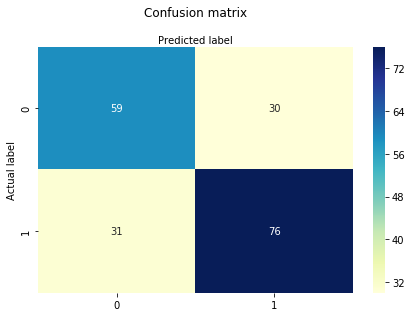

In [15]:
utils.display_confusion_matrix(y_test, y_pred)

In [16]:
prediction_probabilities = rf_classifier.predict_proba(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Log loss= ",log_loss(y_test, prediction_probabilities))

Accuracy: 0.6887755102040817
Precision: 0.7169811320754716
Recall: 0.7102803738317757
Log loss=  0.5931597897427224


In [17]:
cross_val_scores = cross_val_score(rf_classifier, X,y, cv=10, scoring='accuracy')
print("Baseline Cross Validation average= ",cross_val_scores.mean())

Baseline Cross Validation average=  0.7485693246370714


In [18]:
train_sizes, train_scores, test_scores = learning_curve(rf_classifier, 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

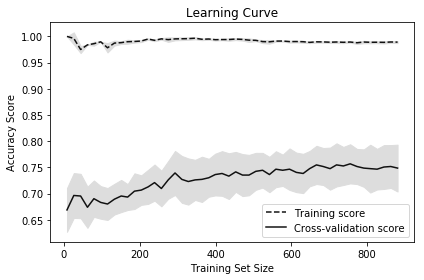

In [19]:
# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [20]:
#param_grid = {
#    
#    "n_estimators": [500,750,1000,2000,3000],
#    "max_features":['sqrt'],
#    "criterion":['entropy'],
#    "min_samples_split": [2],
#    "min_samples_leaf":[2,5],
#    "max_depth": [10]
#}
#grid_search_model = GridSearchCV(estimator=RandomForestClassifier(), param_grid = param_grid, cv=5, 
#                                 n_jobs =-1, scoring='accuracy')

#grid_search_model.fit(X_train, y_train)
#score = grid_search_model.score(X_train, y_train)
#print("Grid Search  Model Score= ", score)


In [21]:
#grid_search_model.best_params_

#### Model Feature Optimization

In [22]:
model_stats = eliminate_features(rf_classifier, X,y)

Iteration=  0
least_important label=  top_conf_t
Iteration=  1
least_important label=  top_conf_o
Iteration=  2
least_important label=  delta_def_rebs_avg
Iteration=  3
least_important label=  delta_off_rebs_avg
Iteration=  4
least_important label=  delta_ft_att_avg
Iteration=  5
least_important label=  delta_to_net_avg
Iteration=  6
least_important label=  delta_margin_victory_avg
Iteration=  7
least_important label=  lose_pts
Iteration=  8
least_important label=  delta_fg_pct
Iteration=  9
least_important label=  delta_off_rating
Iteration=  10
least_important label=  delta_ft_pct
Iteration=  11
least_important label=  win_pts
Iteration=  12
least_important label=  delta_seed
Iteration=  13
least_important label=  delta_rpi
Iteration=  14
least_important label=  delta_wol
Iteration=  15
least_important label=  delta_col
Iteration=  16
least_important label=  delta_dol
Iteration=  17
least_important label=  delta_wlk
Iteration=  18
least_important label=  delta_sos
Iteration=  19
leas

In [23]:
max_accuracy = 0
max_cross_val = 0
min_log_loss = 10000
for key, value in model_stats.items():
    accuracy = value['accuracy']
    cross_val = value['cross_validation']
    log_loss_val = value['log_loss']
    print('Accuracy= {0:6.4f} Cross Val= {1:6.4f}  Log Loss= {2:6.4f}'.format(accuracy ,cross_val, log_loss_val ))
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        accuracy_hash = key
    if cross_val > max_cross_val:
        max_cross_val = cross_val
        cross_hash = key
    if log_loss_val < min_log_loss:
        min_log_loss = log_loss_val
        log_hash = key

print("\n")

print('Max Accuracy= {0:6.4f}'.format( model_stats[accuracy_hash]['accuracy']))
print('Max Cross Validation= {0:6.4f}'.format( model_stats[cross_hash]['cross_validation']))
print ("Minimum Log Loss= {0:6.4f}".format(  model_stats[log_hash]['log_loss']))
print('Log Loss at Max Accuracy= {0:6.4f}'.format( model_stats[accuracy_hash]['log_loss'] ))
print('Log Loss at Max Cross Validation= {0:6.4f} '.format( model_stats[cross_hash]['log_loss'] ))

Accuracy= 0.6888 Cross Val= 0.7486  Log Loss= 0.5932
Accuracy= 0.6633 Cross Val= 0.7526  Log Loss= 0.5919
Accuracy= 0.6684 Cross Val= 0.7496  Log Loss= 0.5905
Accuracy= 0.6684 Cross Val= 0.7495  Log Loss= 0.5896
Accuracy= 0.6735 Cross Val= 0.7536  Log Loss= 0.5895
Accuracy= 0.6786 Cross Val= 0.7557  Log Loss= 0.5878
Accuracy= 0.6786 Cross Val= 0.7567  Log Loss= 0.5903
Accuracy= 0.6786 Cross Val= 0.7598  Log Loss= 0.5914
Accuracy= 0.6837 Cross Val= 0.7639  Log Loss= 0.6027
Accuracy= 0.6786 Cross Val= 0.7669  Log Loss= 0.5985
Accuracy= 0.6684 Cross Val= 0.7690  Log Loss= 0.5976
Accuracy= 0.6582 Cross Val= 0.7710  Log Loss= 0.6058
Accuracy= 0.6684 Cross Val= 0.7730  Log Loss= 0.6064
Accuracy= 0.6786 Cross Val= 0.7751  Log Loss= 0.6046
Accuracy= 0.6837 Cross Val= 0.7751  Log Loss= 0.5996
Accuracy= 0.6684 Cross Val= 0.7771  Log Loss= 0.6006
Accuracy= 0.6888 Cross Val= 0.7782  Log Loss= 0.5991
Accuracy= 0.6990 Cross Val= 0.7771  Log Loss= 0.6050
Accuracy= 0.6735 Cross Val= 0.7802  Log Loss= 

In [24]:
model_features = model_stats[cross_hash]['labels']
print(model_features)

['delta_win_pct', 'delta_srs', 'delta_sos', 'delta_sag', 'delta_rth', 'delta_pom', 'delta_mor']


In [25]:
X=X[model_features]

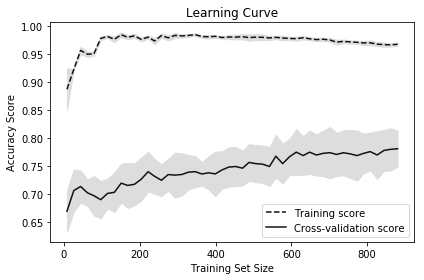

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 5)
rf_classifier.fit(X_train, y_train)



train_sizes, train_scores, test_scores = learning_curve(rf_classifier, 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))


train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

Accuracy: 0.673469387755102
Precision: 0.6972477064220184
Recall: 0.7102803738317757
Log loss=  0.6107603981449475
Cross Validation:  0.7802019776982958


array([[56, 33],
       [31, 76]], dtype=int64)

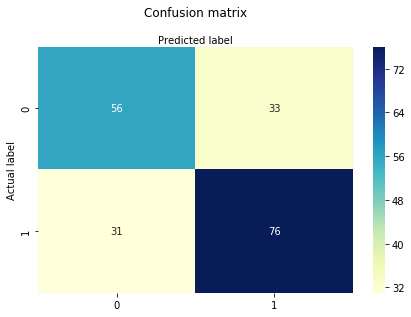

In [27]:
y_pred = rf_classifier.predict(X_test)
# save model stats
prediction_probabilities = rf_classifier.predict_proba(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Log loss= ",log_loss(y_test, prediction_probabilities))
cross_val_scores = cross_val_score(rf_classifier, X,y, cv=10, scoring='accuracy')
print("Cross Validation: ", cross_val_scores.mean())
utils.display_confusion_matrix(y_test, y_pred)

In [28]:
missed_predictions = get_missed_predictions(tourney_comp_ratings, model_features, prediction_probabilities, X_test, y_test, y_pred)
missed_predictions

                                       Kansas                   Bucknell     Stat Supports Winner
Allow PPG                       65.00                              58.00         True  (L)
FT %                            69.50                              70.10         True  (H)
Takeaway Avg                     6.00                               7.00         True  (H)
Seed                              3                                 14          False  (L)
SAG                              9.00                             114.00        False  (L)
WLK                              7.00                              97.00        False  (L)
WOL                             10.00                              84.00        False  (L)
RTH                              7.00                             137.00        False  (L)
COL                              4.00                             102.00        False  (L)
POM                             12.00                             110.00        Fal

DOL                             38.00                              25.00        False  (L)
RPI                             42.00                              14.00        False  (L)
MOR                             38.00                              32.00        False  (L)
Turnover Avg                    13.00                              13.00        False  (L)
SRS                             14.65                              16.24        False  (H)
SOS                              8.89                              10.76        False  (H)
PPG                             69.00                              77.00        False  (H)
Poss Avg                        76.09                              80.38        False  (H)
FG %                            46.00                              47.80        False  (H)
Off Rb Avg                      11.00                              12.00        False  (H)
Def Rb Avg                      21.00                              25.00        False  (H)

,season_t,round,game_date,seed_t,team_t,team_id_t,win_pts,seed_o,team_o,team_id_o,lose_pts,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf_t,top_conf_o,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor,predicted_result,pred_win_prob,supporting_features,supporting_model_features,features,model_features,game_index
128,2005,64,2005-03-18 00:00:00.0000000,3,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,64,14,Bucknell,98d2123a-c7b9-4b5f-8a81-43f76d8537dc,63,-1,2004,Lose,20.68,10.85,0.767,75.0,65.0,0.476,0.695,79.220000,11.0,25.0,14.0,6.0,94.673062,21.0,2.12,-2.19,0.697,63.0,58.0,0.444,0.701,71.569697,9.0,22.0,15.0,7.0,88.026082,20.0,Big 12,Patriot League,9,7.0,10,7,4.0,12.0,8.0,1.0,19,114,97.0,84,137,102.0,110.0,87.0,64.0,151,1,0,1,10.0,5.0,5.0,0.032,2.0,3.0,-0.006,8.0,8.0,0.0,0.070,6.646981,1.0,-11,18.56,13.04,-105,-90.0,-74,-130,-98.0,-98.0,-79.0,-63.0,-132,1,0.997500,[ft_pct],[],4.0,0.000000,128
512,2011,32,2011-03-20 00:00:00.0000000,3,Purdue,12d7f888-675b-459f-9099-a38f771d8a95,94,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,76,-1,2010,Lose,19.36,8.69,0.765,72.0,61.0,0.447,0.715,75.888235,11.0,24.0,10.0,6.0,94.876366,19.0,8.56,3.78,0.700,71.0,66.0,0.434,0.715,75.240000,10.0,21.0,11.0,8.0,94.364700,20.0,Big Ten,Atlantic 10,9,8.0,10,9,13.0,8.0,8.0,12.0,10,77,55.0,54,74,59.0,84.0,72.0,49.0,80,1,0,1,11.0,5.0,6.0,0.013,1.0,3.0,0.000,4.0,3.0,1.0,0.065,0.511667,-1.0,-8,10.80,4.91,-68,-47.0,-44,-65,-46.0,-76.0,-64.0,-37.0,-70,1,0.978180,"[to_net_avg, ft_att_avg]",[],8.0,0.000000,512
178,2005,32,2005-03-19 00:00:00.0000000,2,Wake Forest,4fbebf0a-e117-4a0c-8f15-c247535a2a1b,111,7,West Virginia,f770d3a2-221c-49ce-9c7a-680f7417fe9e,105,-1,2004,Lose,20.24,10.27,0.818,84.0,73.0,0.491,0.684,85.224242,14.0,25.0,14.0,8.0,98.563504,27.0,11.76,7.62,0.686,71.0,67.0,0.450,0.742,73.782857,9.0,20.0,11.0,8.0,96.228315,17.0,Atlantic Coast,Big 12,4,4.0,3,4,6.0,5.0,3.0,7.0,5,38,39.0,28,32,34.0,35.0,30.0,34.0,30,0,0,0,11.0,4.0,7.0,0.041,5.0,5.0,-0.058,6.0,3.0,3.0,0.132,2.335190,10.0,-5,8.48,2.65,-34,-35.0,-25,-28,-28.0,-30.0,-27.0,-27.0,-25,1,0.930717,"[ft_pct, to_net_avg]",[],8.0,0.000000,178
214,2006,8,2006-03-26 00:00:00.0000000,1,Connecticut,efba5350-79bc-47aa-a189-db177b95b491,86,11,George Mason,e76479d0-a768-46d2-89bf-7b9dae12bec8,84,-1,2005,Lose,21.22,6.57,0.882,81.0,67.0,0.473,0.706,86.076471,15.0,28.0,14.0,6.0,94.102371,25.0,12.11,2.77,0.771,69.0,60.0,0.481,0.664,73.440000,10.0,24.0,12.0,7.0,93.954248,18.0,American Athletic,Atlantic 10,2,2.0,2,2,3.0,2.0,2.0,3.0,2,38,25.0,37,53,45.0,28.0,43.0,26.0,75,1,0,1,14.0,9.0,5.0,-0.008,5.0,4.0,0.042,8.0,5.0,3.0,0.111,0.148123,7.0,-10,9.11,3.80,-36,-23.0,-35,-51,-42.0,-26.0,-41.0,-23.0,-73,1,0.891138,"[fg_pct, to_net_avg]",[],8.0,0.000000,214
656,2013,64,2013-03-22 00:00:00.0000000,2,Georgetown,8736b67f-5924-400b-bf94-3bd804c36600,78,15,Florida Gulf Coast,5326c079-3dc3-468f-a601-b776dd9c1e62,68,-1,2012,Lose,15.84,7.59,0.781,64.0,56.0,0.453,0.679,71.050000,9.0,20.0,12.0,7.0,90.077410,18.0,2.76,-2.07,0.703,72.0,66.0,0.462,0.675,79.767568,11.0,22.0,14.0,8.0,90.262248,19.0,Big East,Atlantic Sun,9,11.0,7,8,9.0,12.0,9.0,11.0,11,126,124.0,113,146,115.0,126.0,120.0,93.0,110,1,0,1,8.0,6.0,2.0,-0.009,-2.0,-2.0,0.004,5.0,6.0,-1.0,0.078,-0.184838,-1.0,-13,13.08,9.66,-117

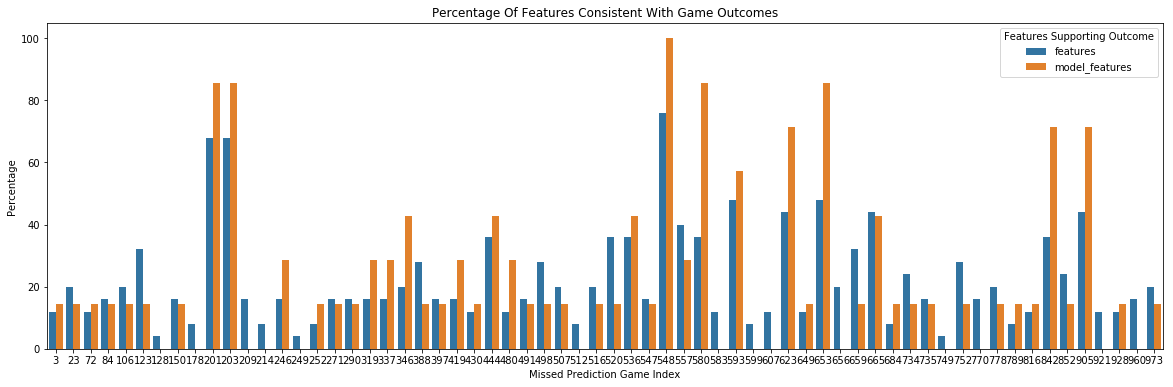

In [29]:
plot_missed_predictions_df = missed_predictions[['game_index','features','model_features']]
plot_missed_predictions_df = pd.melt(plot_missed_predictions_df, id_vars='game_index', var_name= 'Features Supporting Outcome')
m_plot = sns.barplot(x='game_index', y='value', hue='Features Supporting Outcome', data= plot_missed_predictions_df) 
plt.title("Percentage Of Features Consistent With Game Outcomes")
plt.ylabel('Percentage')
plt.xlabel('Missed Prediction Game Index')
m_plot.figure.set_size_inches(20,6)

#### The bar chart depicts the percentage of features that correctly corresponded to the game outcome but were out weighed by other features in predicting the game incorrectly. Games corresponding to bar heights exceeding 50% should be scrutinized.

### Run Model Against 2018 Tournament

In [30]:
test_year = 2018
X_season = feature_data[feature_data['season_t']== test_year][model_features]
y_season = tourney_comp_ratings[tourney_comp_ratings['season_t']== test_year]['game_result']
X_season.shape

(67, 7)

array([[22, 11],
       [ 9, 25]], dtype=int64)

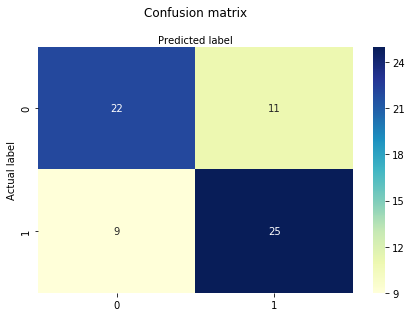

In [31]:
y_pred_season = rf_classifier.predict(X_season)
utils.display_confusion_matrix(y_season,y_pred_season)